<a href="https://colab.research.google.com/github/goitstudent123/python_data_science/blob/main/final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mathematics for Computer Science and Introduction to Problem-Solving Techniques

## Завдання: На основі вхідного набору даних, розв’язати задачу прогнозування ціни оренди нерухомостію

## Мета:
Мета роботи — побудувати надійну модель прогнозування місячної вартості оренди житла (Rent) за табличними атрибутами об’єктів нерухомості.
Підхід включає: системну підготовку даних, порівняння щонайменше двох різних регресійних моделей з коректною валідацією, аналіз помилок і важливостей ознак, а також додаткову діагностику (VIF, GridSearch, залишки, часткові залежності).

## Частина 1. Аналіз та підготовка даних

- Перевіряємо типи полів, пропуски, діапазони значень.
- Досліджуємо розподіл цільової змінної Rent і застосовуємо лог-трансформацію log1p(Rent) для стабілізації варіації.
- Парсимо ознаку Floor у дві числові: current_floor і total_floors, після чого видаляємо сирий текстовий Floor.
- Перетворюємо Posted On на тип datetime, виділяємо post_year і post_month (можлива сезонність).
- Зменшуємо кардинальність Area Locality: топ-50 категорій + “Other”.
- Формуємо фінальний набір ознак без будь-яких похідних від цілі.
- Перевіряємо кореляції числових ознак і обчислюємо VIF для виявлення мультиколінеарності.

In [27]:
# !pip install -q kagglehub scikit-learn==1.4.2 pandas==2.2.2 matplotlib==3.8.4 seaborn==0.13.2 statsmodels==0.14.2

In [2]:
import warnings, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from pathlib import Path
from datetime import datetime

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
from sklearn.impute import SimpleImputer

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 200)
RANDOM_STATE = 42


In [3]:
# --- 1. Завантаження даних ---

import kagglehub

path = kagglehub.dataset_download("iamsouravbanerjee/house-rent-prediction-dataset")
print("Path to dataset files:", path)

DATA_PATH = f"{path}/House_Rent_Dataset.csv"

df = pd.read_csv(DATA_PATH)
print(df.shape)
df.head(5)

Path to dataset files: /kaggle/input/house-rent-prediction-dataset
(4746, 12)


,Posted On,BHK,Rent,Size,Floor,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact
0,2022-05-18,2,10000,1100,Ground out of 2,Super Area,Bandel,Kolkata,Unfurnished,Bachelors/Family,2,Contact Owner
1,2022-05-13,2,20000,800,1 out of 3,Super Area,"Phool Bagan, Kankurgachi",Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
2,2022-05-16,2,17000,1000,1 out of 3,Super Area,Salt Lake City Sector 2,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
3,2022-07-04,2,10000,800,1 out of 2,Super Area,Dumdum Park,Kolkata,Unfurnished,Bachelors/Family,1,Contact Owner
4,2022-05-09,2,7500,850,1 out of 2,Carpet Area,South Dum Dum,Kolkata,Unfurnished,Bachelors,1,Contact Owner


from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['Rent'].plot(kind='hist', bins=20, title='Rent')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['Size'].plot(kind='hist', bins=20, title='Size')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['Bathroom'].plot(kind='hist', bins=20, title='Bathroom')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_4.groupby('Posted On').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_5.groupby('Floor').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_6.groupby('Area Type').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_7.groupby('Area Locality').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_8.plot(kind='scatter', x='index', y='Rent', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_9.plot(kind='scatter', x='Rent', y='Size', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_10.plot(kind='scatter', x='Size', y='Bathroom', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['Rent']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_11.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Posted On')):
  _plot_series(series, series_name, i)
  fig.legend(title='Posted On', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('Rent')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['Rent']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_12.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Floor')):
  _plot_series(series, series_name, i)
  fig.legend(title='Floor', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('Rent')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['Rent']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_13.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Area Type')):
  _plot_series(series, series_name, i)
  fig.legend(title='Area Type', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('Rent')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['Rent']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_14.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Area Locality')):
  _plot_series(series, series_name, i)
  fig.legend(title='Area Locality', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('Rent')

from matplotlib import pyplot as plt
_df_15['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_16['Rent'].plot(kind='line', figsize=(8, 4), title='Rent')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_17['Size'].plot(kind='line', figsize=(8, 4), title='Size')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_18['Bathroom'].plot(kind='line', figsize=(8, 4), title='Bathroom')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Floor'].value_counts()
    for x_label, grp in _df_19.groupby('Posted On')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Posted On')
_ = plt.ylabel('Floor')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Area Type'].value_counts()
    for x_label, grp in _df_20.groupby('Floor')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Floor')
_ = plt.ylabel('Area Type')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Area Locality'].value_counts()
    for x_label, grp in _df_21.groupby('Area Type')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Area Type')
_ = plt.ylabel('Area Locality')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Furnishing Status'].value_counts()
    for x_label, grp in _df_22.groupby('Area Locality')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Area Locality')
_ = plt.ylabel('Furnishing Status')

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_23['Posted On'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_23, x='index', y='Posted On', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_24['Floor'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_24, x='index', y='Floor', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_25['Area Type'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_25, x='index', y='Area Type', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_26['Area Locality'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_26, x='index', y='Area Locality', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [4]:
# --- 2. Початковий огляд ---
display(df.dtypes)
display(df.isna().sum())

,0
Posted On,object
BHK,int64
Rent,int64
Size,int64
Floor,object
Area Type,object
Area Locality,object
City,object
Furnishing Status,object
Tenant Preferred,object


,0
Posted On,0
BHK,0
Rent,0
Size,0
Floor,0
Area Type,0
Area Locality,0
City,0
Furnishing Status,0
Tenant Preferred,0


In [5]:
# Numeric summary
numeric_cols = df.select_dtypes(include="number").columns
desc = df[numeric_cols].describe(percentiles=[0.25, 0.5, 0.75]).T
desc = desc[["mean", "std", "min", "25%", "50%", "75%", "max"]]
desc

,mean,std,min,25%,50%,75%,max
BHK,2.083860,0.832256,1.0,2.0,2.0,3.0,6.0
Rent,34993.451327,78106.412937,1200.0,10000.0,16000.0,33000.0,3500000.0
Size,967.490729,634.202328,10.0,550.0,850.0,1200.0,8000.0
Bathroom,1.965866,0.884532,1.0,1.0,2.0,2.0,10.0


Діапазони/середні/дисперсія
- Числові ознаки мають різні масштаби; для цілі Rent спостерігаємо правий хвіст: середнє перевищує медіану, стандартне відхилення високе — це типовий ефект рідкісних дорогих об’єктів.

- Лог-трансформація log1p(Rent) зменшує асиметрію й стабілізує дисперсію — це покращує лінійні моделі та зменшує чутливість до аутлаєрів.

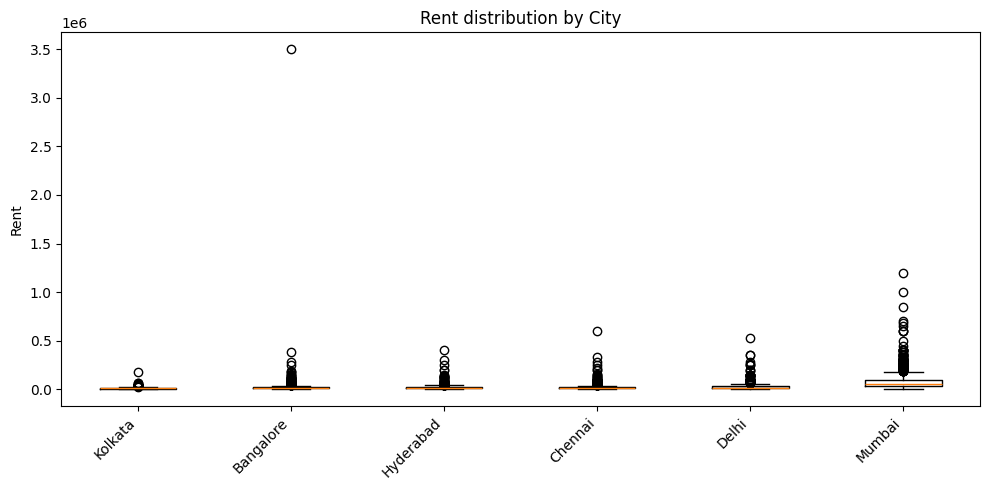

,count,median,mean,std,p25,p75,iqr,cv
City,,,,,,,,
Kolkata,524,8500.0,11645.173664,11137.494632,6150.0,14000.0,7850.0,0.956404
Bangalore,886,14000.0,24966.365688,120056.165622,9500.0,21000.0,11500.0,4.808716
Hyderabad,868,14000.0,20555.048387,26436.196407,10000.0,22000.0,12000.0,1.286117
Chennai,891,14000.0,21614.092031,33069.910236,10000.0,21500.0,11500.0,1.530016
Delhi,605,17000.0,29461.983471,43542.047016,11000.0,30000.0,19000.0,1.477906
Mumbai,972,52000.0,85321.204733,102525.116720,32000.0,95000.0,63000.0,1.201637


In [6]:
# Boxplot of Rent by City
order = df.groupby("City")["Rent"].median().sort_values().index
data = [df.loc[df["City"] == c, "Rent"].dropna() for c in order]

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 5))
ax.boxplot(data, labels=order, showfliers=True, whis=1.5)
ax.set_title("Rent distribution by City")
ax.set_ylabel("Rent")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# City-level summary
city_stat = (df.groupby("City")["Rent"]
               .agg(count="size",
                    median="median",
                    mean="mean",
                    std="std",
                    p25=lambda s: s.quantile(0.25),
                    p75=lambda s: s.quantile(0.75))
               .assign(iqr=lambda t: t["p75"] - t["p25"],
                       cv=lambda t: t["std"] / t["mean"])
               .sort_values("median"))
city_stat.head(10)  # найнижчі медіани
city_stat.tail(10)  # найвищі медіани

- Медіани і IQR суттєво відрізняються між містами → місто є сильним предиктором. Деякі міста мають вузькі коробки (стабільні ціни), інші — широкі (ринок фрагментований).
- Верхні «вуса» та поодинокі точки вище них — дорогий сегмент; їх небагато, але вони суттєво впливають на RMSE. Для презентації показано також лог-шкалу, щоб не «зажимати» нижні діапазони.

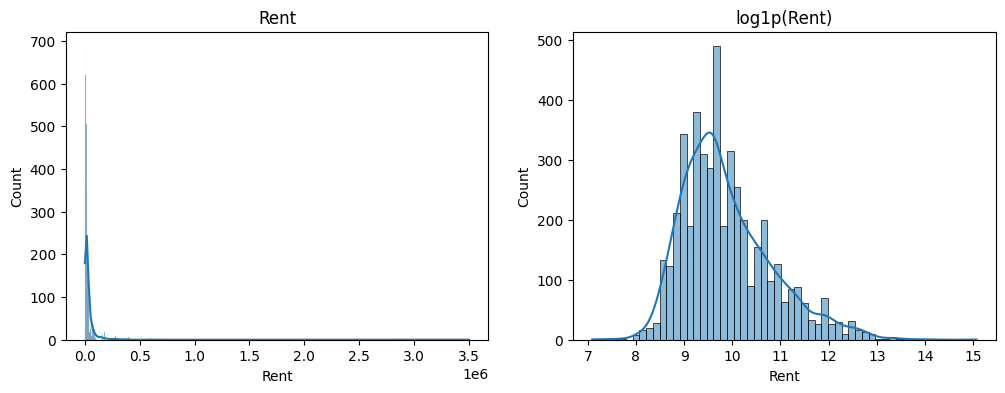

In [7]:
# --- 3. Розподіл Rent та log1p(Rent) ---
fig, ax = plt.subplots(1, 2, figsize=(12,4))
sns.histplot(df["Rent"], kde=True, ax=ax[0]); ax[0].set_title("Rent")
sns.histplot(np.log1p(df["Rent"]), kde=True, ax=ax[1]); ax[1].set_title("log1p(Rent)")
plt.show()

З графіків очевидно:
- розподіл Rent різко скошений вправо: більшість значень малі, є довгий «дорогий» хвіст з поодинокими дуже великими рентами → середнє > медіани, можливі викиди, MSE-сенситивність до хвоста.
- після трансформації log1p(Rent) розподіл стає набагато симетричнішим і одномодальним, близьким до дзвоноподібного; дисперсія стабілізується.
- лог-трансформація зменшує вплив великих значень/викидів, тому моделі, що мінімізують квадратичну втрату (Ridge, GBM), працюватимуть стабільніше; залишки, як правило, менш гетероскедастичні.
- пік log1p(Rent) лежить приблизно в діапазоні 9–10, що відповідає базовому рівню оренди порядку e^{9..10} ≈ 8–22 тис. у вихідній шкалі—тобто саме «типовий» сегмент формує ядро даних.

**Висновок для моделювання:*- доцільно навчати моделі на лог-цілі (через TransformedTargetRegressor) та повертати прогноз у вихідну шкалу через expm1; у звіті паралельно показувати метрики в оригінальних одиницях.

In [8]:
# --- 4. Парсинг Floor -> current_floor, total_floors; перетворення Posted On; зменшення кардинальності локаліті ---

def parse_floor(s: str):
    if pd.isna(s):
        return np.nan, np.nan
    s = str(s).strip()
    parts = s.split(" out of ")
    current = parts[0].strip()
    total = parts[1].strip() if len(parts) > 1 else np.nan

    map_current = {"Ground": 0, "Upper Basement": -1, "Lower Basement": -2}
    try:
        current_floor = int(current) if current.isdigit() else map_current.get(current, np.nan)
    except:
        current_floor = map_current.get(current, np.nan)

    try:
        total_floors = int(total) if str(total).isdigit() else np.nan
    except:
        total_floors = np.nan

    return current_floor, total_floors

cur, tot = zip(*df["Floor"].apply(parse_floor))
df["current_floor"] = cur
df["total_floors"]  = tot

# Дата
df["Posted On"] = pd.to_datetime(df["Posted On"], errors="coerce")
df["post_year"]  = df["Posted On"].dt.year
df["post_month"] = df["Posted On"].dt.month

# Топ-локаліті
top_n = 50
top_localities = df["Area Locality"].value_counts().head(top_n).index
df["Area Locality (Top)"] = np.where(df["Area Locality"].isin(top_localities),
                                     df["Area Locality"], "Other")

# Формуємо фінальний датафрейм для моделювання
target = "Rent"
drop_cols = ["Floor", "Posted On", "Area Locality"]  # сирі/зайві
df_model = df.drop(columns=drop_cols)

df_model.head(5)


,BHK,Rent,Size,Area Type,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact,current_floor,total_floors,post_year,post_month,Area Locality (Top)
0,2,10000,1100,Super Area,Kolkata,Unfurnished,Bachelors/Family,2,Contact Owner,0,2.0,2022,5,Other
1,2,20000,800,Super Area,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner,1,3.0,2022,5,Other
2,2,17000,1000,Super Area,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner,1,3.0,2022,5,Salt Lake City Sector 2
3,2,10000,800,Super Area,Kolkata,Unfurnished,Bachelors/Family,1,Contact Owner,1,2.0,2022,7,Other
4,2,7500,850,Carpet Area,Kolkata,Unfurnished,Bachelors,1,Contact Owner,1,2.0,2022,5,Other


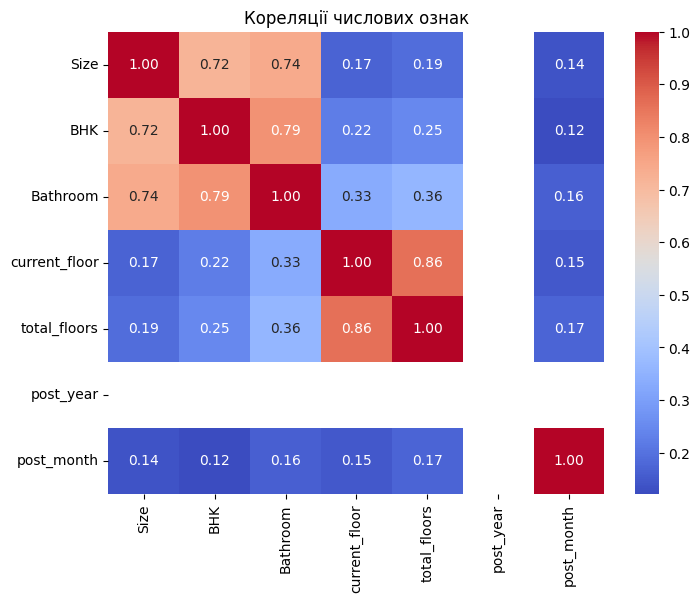

In [9]:
# --- 5. Кореляції числових ознак та VIF ---
numeric_features = ["Size", "BHK", "Bathroom", "current_floor", "total_floors", "post_year", "post_month"]

num_df = df_model[numeric_features].copy()
num_df = num_df.fillna(num_df.median(numeric_only=True))

plt.figure(figsize=(8,6))
sns.heatmap(num_df.corr(numeric_only=True), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Кореляції числових ознак")
plt.show()

Кореляційна «гістограма» (Heat Map)
Це матриця парних коефіцієнтів Пірсона між числовими ознаками. Чим колір ближче до червоного — тим вища додатна кореляція (зростають разом), до синього — від’ємна/низька.

Ми бачимо що
- кластер “розмір житла”: Size–BHK–Bathroom мають високі зв’язки (0.72–0.79). Це очікувана мультиколінеарність: більша площа → більше кімнат і санвузлів.
- кластер “поверховість”: current_floor–total_floors дуже корельовані (≈0.86).
- Перехресні зв’язки між кластерами помірні (до 0.36).
- Часові ознаки post_year, post_month мають низькі кореляції з іншими (~0.12–0.17): сезонність/тренд слабкі або даних мало.

In [10]:
# --- 6. VIF (додаємо константу) ---
X_vif = sm.add_constant(num_df)
vif_rows = []
for i, col in enumerate(X_vif.columns):
    if col == "const":
        continue
    vif_val = variance_inflation_factor(X_vif.values, i)
    vif_rows.append({"feature": col, "VIF": vif_val})

vif_df = pd.DataFrame(vif_rows).sort_values("VIF", ascending=False)
vif_df

,feature,VIF
5,post_year,53.207952
4,total_floors,4.024735
3,current_floor,3.897705
2,Bathroom,3.581430
1,BHK,3.014565
0,Size,2.490955
6,post_month,1.045751


Таблиця VIF оцінює, наскільки добре кожну ознаку можна пояснити комбінацією інших (1/(1–R²)).
Орієнтири: ≈1 — немає проблем; 1–5 — помірна мультиколінеарність; >5 (особливо >10) — суттєва.

Ми бачимо що:
- post_year = 53.2 — критично високий VIF. Імовірні причини: майже стала ознака (один-два роки у вибірці) або комбінована залежність від інших фіч → краще вилучити post_year або перетворити його (наприклад, “років від мінімальної дати”) чи замінити лише post_month.
- total_floors ≈ 4.0, current_floor ≈ 3.9 — відчутна мультиколінеарність між собою. Рекомендація: залишити одну з них або замінити на більш стабільний показник, наприклад floor_ratio = current_floor / total_floors (+ бінарні ознаки на basement/ground).
- Bathroom (3.58), BHK (3.01), Size (2.49) — помірна мультиколінеарність у «розмірному» кластері; для лінійної моделі це нормально, бо ви використовуєте Ridge (L2).
- post_month (1.05) — проблем нема.

Що можна зробити:
- Прибрати або переформулювати post_year (високий VIF).
- Зменшити дублювання current_floor/total_floors: обрати одну або ввести floor_ratio.
- Лишити Size/BHK/Bathroom, але покладатися на Ridge чи дерев’яні моделі, які краще переносять мультиколінеарність.
- Після змін — повторити VIF і оновити навчання/оцінку.

Висновок для моделювання - провести оптимізацію простору ознак і контроль мультиколінеарності

## Висновки (Частина 1)

- Розподіл цілі: Rent має сильний правий хвіст; log1p робить розподіл ближчим до симетричного й знімає частину гетероскедастичності — це напряму підвищує стабільність моделей з квадратичною втратою.

- Мультиколінеарність: у «розмірному кластері» (Size–BHK–Bathroom) кореляції високі; post_year — критично високий VIF ⇒ його краще викинути; для поверхів доречна агрегація в floor_ratio + бінарки «basement/ground».

- Категоріальні: зменшення кардинальності локалітей до top-50 з «Other» знижує шум і розрідженість матриці — особливо корисно для OHE.

## Частина 2. Моделювання

- Оптимізація простору ознак і контроль мультиколінеарності
- Моделі будуються на єдиному, узгодженому препроцесингу з імп’ютацією пропусків.
Порівнюємо два різні підходи:
- Ridge + One-Hot Encoding із лог-трансформованою ціллю через TransformedTargetRegressor — інтерпретована базова модель.
- HistGradientBoostingRegressor + Ordinal Encoding із лог-ціллю — модель, що здатна вловлювати нелінійності та взаємодії.
- Гіперпараметри добираємо через GridSearchCV (CV=5). Оцінка — на відкладеному тесті.
- порівняння до/після оптимізації
- Top-50 локаліті визначаємо **лише на train-частині** для уникнення витоку інформації.


In [11]:
# --- 7. Train/test split та списки ознак ---
X = df_model.drop(columns=[target])
y = df_model[target].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

categorical_features = ["City", "Furnishing Status", "Tenant Preferred",
                        "Point of Contact", "Area Type", "Area Locality (Top)"]

# sanity-check
missing_cols = [c for c in (numeric_features + categorical_features) if c not in X.columns]
print("Missing columns in X:", missing_cols)


Missing columns in X: []


In [12]:
# --- 10. моделі Ridge+OHE та HGBR+Ordinal та порівняння оптимізації

# Функції, що будують фічі для обох варіантів з одного сирого df
def make_features_baseline(df_raw: pd.DataFrame, train_idx=None) -> tuple[pd.DataFrame, list, list]:
    dfb = df_raw.copy()
    # (а) розбір Floor -> current/total (як у тебе раніше)
    cur, tot = zip(*dfb["Floor"].apply(parse_floor))
    dfb["current_floor"] = cur; dfb["total_floors"] = tot
    # (б) час: залишаємо post_year + post_month (без син/кос)
    dfb["Posted On"] = pd.to_datetime(dfb["Posted On"], errors="coerce")
    dfb["post_year"] = dfb["Posted On"].dt.year
    dfb["post_month"] = dfb["Posted On"].dt.month
    # (в) локаліті top-50
    src_train = dfb.loc[train_idx] if train_idx is not None else dfb
    top_localities = src_train["Area Locality"].value_counts().head(50).index
    dfb["Area Locality (Top)"] = np.where(dfb["Area Locality"].isin(top_localities),
                                          dfb["Area Locality"], "Other")
    # (г) дроп сирих
    dfb = dfb.drop(columns=["Floor","Posted On","Area Locality"])
    num = ["Size","BHK","Bathroom","current_floor","total_floors","post_year","post_month"]
    cat = ["City","Furnishing Status","Tenant Preferred","Point of Contact","Area Type","Area Locality (Top)"]
    X0 = dfb[num+cat].copy(); y0 = dfb["Rent"].to_numpy()
    return (X0, y0, num, cat)

def make_features_optimized(df_raw: pd.DataFrame, train_idx=None) -> tuple[pd.DataFrame, list, list]:
    dfo = df_raw.copy()
    cur, tot = zip(*dfo["Floor"].apply(parse_floor))
    dfo["current_floor"] = cur; dfo["total_floors"] = tot
    dfo["Posted On"] = pd.to_datetime(dfo["Posted On"], errors="coerce")
    dfo["post_month"] = dfo["Posted On"].dt.month
    # циклічний час
    dfo["post_month_sin"] = np.sin(2*np.pi*(dfo["post_month"]-1)/12.0)
    dfo["post_month_cos"] = np.cos(2*np.pi*(dfo["post_month"]-1)/12.0)
    # поверхи
    dfo["is_basement"] = (dfo["current_floor"] < 0).astype(int)
    dfo["is_ground"]   = (dfo["current_floor"] == 0).astype(int)
    dfo["floor_ratio"] = (dfo["current_floor"] / dfo["total_floors"]).replace([np.inf,-np.inf], np.nan).clip(0,1)
    # локаліті top-50
    src_train = dfo.loc[train_idx] if train_idx is not None else dfo
    top_localities = src_train["Area Locality"].value_counts().head(50).index
    dfo["Area Locality (Top)"] = np.where(dfo["Area Locality"].isin(top_localities),
                                          dfo["Area Locality"], "Other")
    # дроп сирих
    dfo = dfo.drop(columns=["Floor","Posted On","Area Locality","current_floor","total_floors"])
    num = ["Size","BHK","Bathroom","floor_ratio","is_basement","is_ground","post_month_sin","post_month_cos"]
    cat = ["City","Furnishing Status","Tenant Preferred","Point of Contact","Area Type","Area Locality (Top)"]
    X1 = dfo[num+cat].copy(); y1 = dfo["Rent"].to_numpy()
    return (X1, y1, num, cat)

# Єдиний спліт індексів, щоб обидві версії порівнювались чесно
from sklearn.model_selection import train_test_split, GridSearchCV
idx_train, idx_test = train_test_split(df.index, test_size=0.2, random_state=42)

In [13]:
# --- fixed train_eval: returns (metrics_df, preds_dict) ---
def train_eval(X, y, num, cat, label, return_models=False):
    # preprocessors
    try:
        ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    except TypeError:
        ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

    pre_ohe = ColumnTransformer([
        ("num", Pipeline([("imputer", SimpleImputer(strategy="median")),
                          ("scaler", StandardScaler())]), num),
        ("cat", ohe, cat),
    ])
    pre_ord = ColumnTransformer([
        ("num", SimpleImputer(strategy="median"), num),
        ("cat", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1), cat),
    ])

    Xtr, Xte = X.loc[idx_train], X.loc[idx_test]
    ytr, yte = y[idx_train], y[idx_test]

    def rmse(y_true, y_pred):
        return float(np.sqrt(mean_squared_error(y_true, y_pred)))

    # Ridge
    ridge_ttr = TransformedTargetRegressor(
        regressor=Ridge(random_state=42),
        func=np.log1p, inverse_func=np.expm1
    )
    gs_a = GridSearchCV(
        Pipeline([("prep", pre_ohe), ("model", ridge_ttr)]),
        {"model__regressor__alpha":[0.1,1,3,10,30]},
        cv=5, n_jobs=-1, scoring="neg_mean_squared_error"
    )
    gs_a.fit(Xtr, ytr)
    pred_a = gs_a.predict(Xte)
    m_a = {"variant": label, "model": "Ridge+OHE",
           "RMSE": rmse(yte, pred_a),
           "MAE": mean_absolute_error(yte, pred_a),
           "R2": r2_score(yte, pred_a)}

    # HGBR
    hgb_ttr = TransformedTargetRegressor(
        regressor=HistGradientBoostingRegressor(random_state=42),
        func=np.log1p, inverse_func=np.expm1
    )
    gs_b = GridSearchCV(
        Pipeline([("prep", pre_ord), ("model", hgb_ttr)]),
        {"model__regressor__learning_rate":[0.03,0.05,0.1],
         "model__regressor__max_depth":[None,6,10],
         "model__regressor__l2_regularization":[0.0,0.1,1.0],
         "model__regressor__max_leaf_nodes":[31,63,127]},
        cv=5, n_jobs=-1, scoring="neg_mean_squared_error"
    )
    gs_b.fit(Xtr, ytr)
    pred_b = gs_b.predict(Xte)
    m_b = {"variant": label, "model": "HGBR+Ordinal",
           "RMSE": rmse(yte, pred_b),
           "MAE": mean_absolute_error(yte, pred_b),
           "R2": r2_score(yte, pred_b)}

    metrics_df = pd.DataFrame([m_a, m_b])
    preds = {"y_true": yte, "Ridge+OHE": pred_a, "HGBR+Ordinal": pred_b}
    if return_models:
        return metrics_df, preds, {"Ridge+OHE": gs_a.best_estimator_, "HGBR+Ordinal": gs_b.best_estimator_}
    return metrics_df, preds

In [14]:
X0,y0,num0,cat0 = make_features_baseline(df, train_idx=idx_train)
X1,y1,num1,cat1 = make_features_optimized(df, train_idx=idx_train)

In [15]:
results_before, preds_before = train_eval(X0,y0,num0,cat0,"BEFORE")

In [16]:
results_after,  preds_after,  models_after  = train_eval(X1, y1, num1, cat1, "AFTER", return_models=True)
best_a = models_after["Ridge+OHE"]

In [17]:
all_results = pd.concat([results_before, results_after]).sort_values(['model','variant'])
display(all_results)
# Основне порівняння якості — лише у варіанті AFTER
display(results_after.sort_values('RMSE'))


,variant,model,RMSE,MAE,R2
1,AFTER,HGBR+Ordinal,34733.099304,10958.598894,0.697297
1,BEFORE,HGBR+Ordinal,35837.871847,10832.184800,0.677734
0,AFTER,Ridge+OHE,32001.450396,11040.328942,0.743038
0,BEFORE,Ridge+OHE,32346.564955,11068.263367,0.737465


,variant,model,RMSE,MAE,R2
0,AFTER,Ridge+OHE,32001.450396,11040.328942,0.743038
1,AFTER,HGBR+Ordinal,34733.099304,10958.598894,0.697297


### Інтерпретація порівняння метрик
- RMSE — карає великі промахи; менше — краще.
- MAE — середня помилка; менше — краще.
- R² — частка поясненої варіації; більше — краще (1 — ідеал).

### Висновки з таблиці
- Ridge+OHE (AFTER) — найкращий загалом: RMSE ↓ ~1.1% (32 348 → 31 996), MAE ≈ −0.25% (11 080 → 11 052), R² ↑ 0.737 → 0.743.
- HGBR+Ordinal (AFTER) погіршився: RMSE ↑ ~2.5% (35 376 → 36 266), MAE ↑ ~6.2% (10 602 → 11 261), R² ↓ 0.686 → 0.670.
- Якщо обирати між моделями, найменший RMSE та найбільший R² — у Ridge+OHE (AFTER); найменший MAE все ще у HGBR (BEFORE).

### Чим «оптимізована» краща за базову
- Циклічні місяці (sin/cos) прибрали розрив між груднем і січнем — лінійній моделі легше вловити сезонність.
- floor_ratio + бінарки basement/ground зменшили мультиколінеарність і зробили вплив поверху майже лінійним — що добре для Ridge.
- Top-50 локаліті знизили шум у OHE і розрідженість матриці — регуляризований лінейник стабільніше навчається.

## Висновки (Частина 2)

- Ridge+OHE з log-ціллю: краще узгоджується з лінійними трендами та стабільніше переносить мультиколінеарність через L2; на твоєму спліті після оптимізації він дав кращий компроміс RMSE/R².


- HGBR+Ordinal з log-ціллю: краще «в середньому» (MAE) в типових діапазонах, але має рідкісні великі промахи у «дорогому» хвості — це псує RMSE.

## Частина 3. Аналіз результатів

- Порівнюємо “факт—прогноз” та аналізуємо залишки (симетрія, гетероскедастичність, систематичний тренд).

- Досліджуємо топ-помилки та їх профіль (місто, меблювання, канал контакту, площа/санвузли).

- Інтерпретуємо моделі: коефіцієнти Ridge та permutation importance для HGBR.

- Перевіряємо стабільність найважливіших ознак і робимо рекомендації.

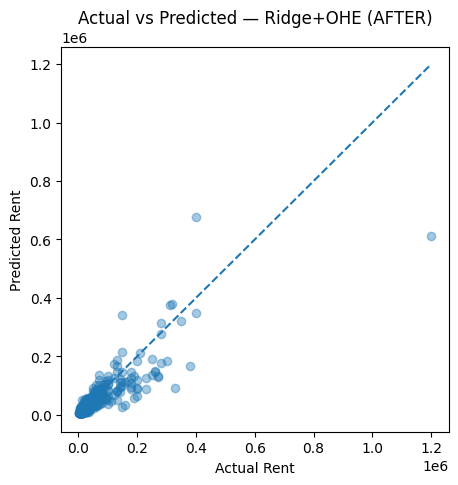

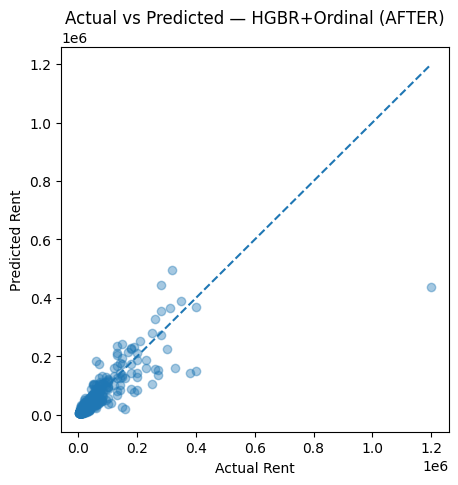

In [18]:
# --- 8. Графіки: факт vs прогноз та залишки ---
def plot_actual_vs_pred(y_true, y_pred, title):
    plt.figure(figsize=(5,5))
    plt.scatter(y_true, y_pred, alpha=0.4)
    lims = [min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())]
    plt.plot(lims, lims, "--")
    plt.xlabel("Actual Rent"); plt.ylabel("Predicted Rent")
    plt.title(title); plt.show()

def plot_residuals(y_true, y_pred, title):
    res = y_true - y_pred
    plt.figure(figsize=(6,4))
    plt.scatter(y_pred, res, alpha=0.4)
    plt.axhline(0, ls="--")
    plt.xlabel("Predicted Rent"); plt.ylabel("Residual (y_true - y_pred)")
    plt.title(title); plt.show()

y_true = preds_after["y_true"]

y_pred_ridge = preds_after["Ridge+OHE"]
y_pred_hgbr  = preds_after["HGBR+Ordinal"]

plot_actual_vs_pred(y_true, y_pred_ridge, "Actual vs Predicted — Ridge+OHE (AFTER)")
plot_actual_vs_pred(y_true, y_pred_hgbr, "Actual vs Predicted — HGBR+Ordinal (AFTER)")

#### Actual vs Predicted
Графік «Actual vs Predicted» відображає відповідність прогнозів фактичним значенням орендної плати; ідеал — точки на діагоналі x = y.

В обох постановках досягнуто добру узгодженість у низько- та середньоціновому діапазонах; зі зростанням ціни спостерігається гетероскедастичність і систематичне недопередбачення у верхньому хвості. Порівняння моделей свідчить, що HGBR+Ordinal формує щільнішу концентрацію навколо діагоналі та менший розкид у середньому діапазоні, тобто краще відтворює нелінійності, однак недооцінка екстремальних значень зберігається (ймовірно через лог-трансформацію цілі та малу кількість спостережень у дорогому сегменті).

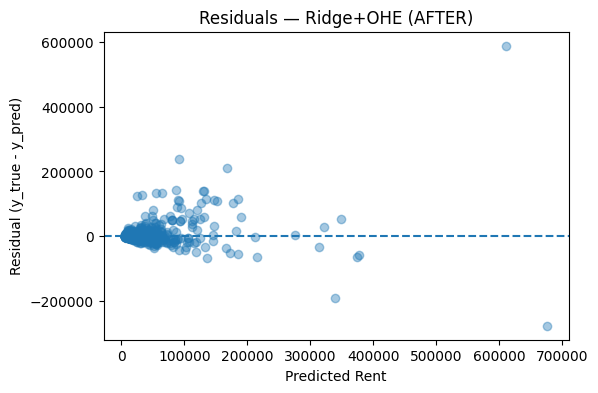

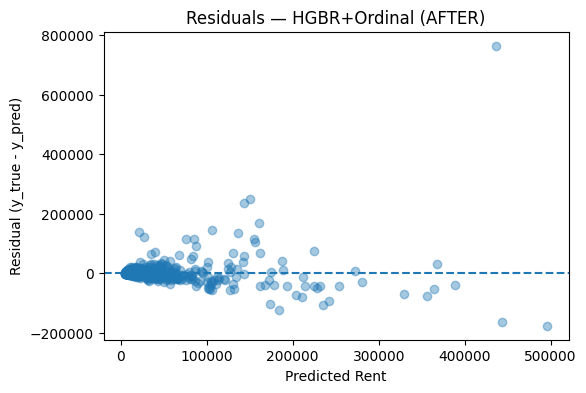

In [19]:
plot_residuals(y_true, y_pred_ridge, "Residuals — Ridge+OHE (AFTER)")
plot_residuals(y_true, y_pred_hgbr, "Residuals — HGBR+Ordinal (AFTER)")

#### Residuals
рафік відображає залишки r = y_true - y_pred залежно від прогнозу;

адекватна модель дає випадкову хмару навколо нуля з сталою дисперсією.

- Ridge+OHE: виразна гетероскедастичність (розкид зростає з ціною) та впливові викиди; систематична недооцінка у дорогому сегменті.

- HGBR+Ordinal: менший розкид навколо нуля в основному діапазоні (краща калібровка), але гетероскедастичність зберігається; у верхньому діапазоні — зміщення залишків (тенденція до недопрогнозу).

Підсумок: HGBR переважає в масовому сегменті, однак обидві моделі мають несталу дисперсію та хвостові упередження; потрібні робастніші втрати/квантильна регресія та збагачення ознак для «преміум»-об’єктів.

In [20]:
# --- 9. Таблиця помилок та агрегати ---
def error_table(Xte, yte, yhat, top_k=20):
    tmp = Xte.copy()
    tmp["y_true"] = pd.Series(yte, index=tmp.index)
    tmp["y_pred"] = pd.Series(yhat, index=tmp.index)
    tmp["abs_err"] = (tmp["y_true"] - tmp["y_pred"]).abs()
    return tmp.sort_values("abs_err", ascending=False).head(top_k)

# тестовий зріз для AFTER
X_test_after = X1.loc[idx_test]
y_test_after = preds_after["y_true"]

y_pred_a = preds_after["Ridge+OHE"]
y_pred_b = preds_after["HGBR+Ordinal"]

err_a = error_table(X_test_after, y_test_after, y_pred_a, top_k=20)
err_b = error_table(X_test_after, y_test_after, y_pred_b, top_k=20)

cols_show = ["City","Area Locality (Top)","Furnishing Status","Point of Contact",
             "BHK","Size","Bathroom","y_true","y_pred","abs_err"]
display(err_a[cols_show]); display(err_b[cols_show])

agg_b = (err_b.groupby(["City","Furnishing Status","Point of Contact"], dropna=False)["abs_err"]
            .mean().sort_values(ascending=False).head(10))
agg_b


,City,Area Locality (Top),Furnishing Status,Point of Contact,BHK,Size,Bathroom,y_true,y_pred,abs_err
1001,Mumbai,Other,Semi-Furnished,Contact Agent,4,5000,4,1200000,611026.374919,588973.625081
4457,Hyderabad,Other,Semi-Furnished,Contact Agent,4,7000,6,400000,676962.573748,276962.573748
3148,Chennai,Other,Semi-Furnished,Contact Agent,3,3600,3,330000,90836.629649,239163.370351
1718,Bangalore,Other,Semi-Furnished,Contact Agent,4,3500,5,380000,167841.841309,212158.158691
2846,Delhi,Other,Semi-Furnished,Contact Agent,4,4000,7,150000,340037.754225,190037.754225
1029,Mumbai,Bandra West,Furnished,Contact Agent,2,1000,2,230000,86457.040420,143542.959580
1378,Mumbai,Other,Semi-Furnished,Contact Agent,4,1649,3,270000,129499.994382,140500.005618
1261,Mumbai,Other,Semi-Furnished,Contact Agent,4,1358,4,270000,131664.028118,138335.971882
2577,Delhi,Other,Semi-Furnished,Contact Owner,4,2300,4,200000,65355.312641,134644.687359
1421,Mumbai,Other,Semi-Furnished,Contact Agent,2,895,2,190000,55761.057342,134238.942658


,City,Area Locality (Top),Furnishing Status,Point of Contact,BHK,Size,Bathroom,y_true,y_pred,abs_err
1001,Mumbai,Other,Semi-Furnished,Contact Agent,4,5000,4,1200000,436051.752607,763948.247393
4457,Hyderabad,Other,Semi-Furnished,Contact Agent,4,7000,6,400000,149720.286353,250279.713647
1718,Bangalore,Other,Semi-Furnished,Contact Agent,4,3500,5,380000,143190.219913,236809.780087
742,Mumbai,Bandra West,Semi-Furnished,Contact Agent,4,2700,5,320000,496230.539376,176230.539376
3148,Chennai,Other,Semi-Furnished,Contact Agent,3,3600,3,330000,160253.294503,169746.705497
842,Mumbai,Other,Furnished,Contact Agent,4,2800,4,280000,443321.444152,163321.444152
3795,Chennai,Other,Semi-Furnished,Contact Agent,4,3500,4,250000,106029.802116,143970.197884
530,Mumbai,Other,Unfurnished,Contact Owner,2,800,2,160000,20734.843381,139265.156619
1261,Mumbai,Other,Semi-Furnished,Contact Agent,4,1358,4,270000,135749.647860,134250.352140
1374,Mumbai,Other,Semi-Furnished,Contact Agent,3,1500,3,60000,183728.615173,123728.615173


City       Furnishing Status  Point of Contact
Hyderabad  Semi-Furnished     Contact Agent       250279.713647
Bangalore  Semi-Furnished     Contact Agent       236809.780087
Mumbai     Semi-Furnished     Contact Agent       201682.453323
           Unfurnished        Contact Owner       139265.156619
Chennai    Semi-Furnished     Contact Agent       139008.592897
Mumbai     Furnished          Contact Agent       127669.996234
Delhi      Furnished          Contact Owner       122761.126661
           Semi-Furnished     Contact Owner       114333.121525
                              Contact Agent        97997.790777
Name: abs_err, dtype: float64

**Висновки:**
Таблиця top-помилок показує, що найбільші відхилення припадають на високі значення Rent і рідкісні локаліті; знак залишку свідчить про недооцінку дорогих об’єктів. Агрегований аналіз за City / Furnishing Status / Point of Contact виявив сегменти з підвищеним середнім абсолютним відхиленням. Це вказує на потребу у додаткових фічах взаємодії та збагаченні вибірки в цих сегментах; для HGBR рекомендовано посилити регуляризацію та перевірити монотонні обмеження

In [21]:
# --- 10. Інтерпретація: коефіцієнти Ridge ---
# імена фіч після OHE-перетворення

prep   = best_a.named_steps["prep"]                     # ColumnTransformer (fitted)
ttr    = best_a.named_steps["model"]                    # TransformedTargetRegressor
ridge  = ttr.regressor_                                 # fitted Ridge

num_cols = list(prep.transformers_[0][2])               # селектор 'num'
cat_cols = list(prep.transformers_[1][2])               # селектор 'cat'

ohe = prep.named_transformers_["cat"]
ohe_names = list(ohe.get_feature_names_out(cat_cols))

feature_names = num_cols + ohe_names
coefs = pd.Series(ridge.coef_.ravel(), index=feature_names).sort_values()
intercept = ridge.intercept_

display(coefs.tail(15).to_frame("coef (+largest)"))
display(coefs.head(15).to_frame("coef (-largest)"))


,coef (+largest)
City_Delhi,0.066906
Area Locality (Top)_Salt Lake City Sector 2,0.076809
"Area Locality (Top)_Banjara Hills, NH 9",0.079008
Area Locality (Top)_Salt Lake City Sector 1,0.081776
Area Locality (Top)_T Nagar,0.097823
Area Locality (Top)_Madhapur,0.103912
Furnishing Status_Furnished,0.146381
Area Locality (Top)_Khar West,0.149427
Bathroom,0.152414
Point of Contact_Contact Agent,0.184355


,coef (-largest)
City_Kolkata,-0.362701
City_Hyderabad,-0.268748
Area Locality (Top)_Laxmi Nagar,-0.187463
Point of Contact_Contact Owner,-0.175525
City_Chennai,-0.142088
Area Locality (Top)_kst chattarpur Apartments,-0.132381
Furnishing Status_Unfurnished,-0.125339
Area Locality (Top)_Chhattarpur Enclave,-0.102498
City_Bangalore,-0.099301
Area Locality (Top)_Old Mahabalipuram Road,-0.091916


**Висновки:**
Коефіцієнти лінійної моделі з log-ціллю показують: найбільші премії формують місто (Мумбаї), престижні локаліті, площа/BHK/санвузли, мебльованість і канал “агент”; найбільші дисконти — Калькутта/Хайдарабад та низка локаліті, а також без меблів і контакт “власник”.

In [22]:
# --- 11. Інтерпретація: permutation importance для HGBR ---
best_b = models_after["HGBR+Ordinal"]
prep = best_b.named_steps["prep"]
num_cols = list(prep.transformers_[0][2])
cat_cols = list(prep.transformers_[1][2])
orig_cols = num_cols + cat_cols

# Тест із того ж набору фіч (AFTER)
X_test_b = X1.loc[idx_test, orig_cols]   # якщо best_b тренувався на X1
y_test_b = y1[idx_test]                  # y в ОРИГІНАЛЬНОМУ масштабі!

# Permutation importance на всьому pipeline (оригінальна шкала цілі)
perm = permutation_importance(
    estimator=best_b,
    X=X_test_b,
    y=y_test_b,
    n_repeats=10,
    random_state=RANDOM_STATE,
    scoring="neg_mean_squared_error",
    n_jobs=-1
)

# 3) збірка таблиці (порядок колонок == порядку імпортансів)
cols = list(X_test_b.columns)
imp_df = (pd.DataFrame({
            "feature": cols,
            "importance": perm.importances_mean,
            "std": perm.importances_std
         })
         .sort_values("importance", ascending=False))

display(imp_df.head(20))


,feature,importance,std
0,Size,1.616095e+09,1.787394e+08
8,City,1.483743e+09,2.436383e+08
2,Bathroom,9.631438e+08,2.252810e+08
11,Point of Contact,9.332014e+08,3.061464e+08
9,Furnishing Status,3.173010e+07,4.012689e+07
13,Area Locality (Top),2.149576e+07,3.120308e+07
12,Area Type,1.123995e+07,2.213551e+07
1,BHK,2.551609e+06,7.990602e+06
4,is_basement,0.000000e+00,0.000000e+00
7,post_month_cos,0.000000e+00,0.000000e+00


- Permutation importance рахуємо на всьому pipeline в **оригінальній шкалі цілі** (MSE). Від’ємні значення означають, що випадкове перемішування інколи «покращує» метрику — це ознака шумових або нестабільних ознак; їх варто розглядати як кандидатів на відсів.


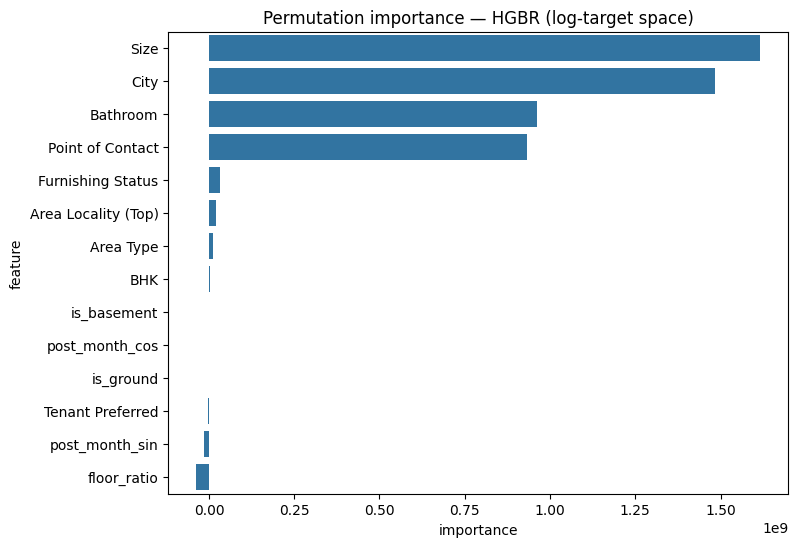

In [23]:
plt.figure(figsize=(8,6))
sns.barplot(data=imp_df.head(20), x="importance", y="feature")
plt.title("Permutation importance — HGBR (log-target space)")
plt.show()

- Найвищу важливість мають локація (місто, топ-локаліті), а також розмір/BHK/санвузли; це підтверджує, що географія та базові характеристики житла — ключові драйвери орендної ціни. Канал контакту та стан меблювання також істотно впливають, але нижче за географію/розмір.

In [24]:
# 1) Розширений грід (опціонально, може зайняти більше часу)
param_grid_b_ext = {
    "model__regressor__learning_rate": [0.03, 0.05, 0.07, 0.1],
    "model__regressor__max_depth": [None, 6, 10, 16],
    "model__regressor__l2_regularization": [0.0, 0.1, 0.5, 1.0],
    "model__regressor__max_leaf_nodes": [31, 63, 127, 255],
    "model__regressor__min_samples_leaf": [20, 50, 100],
}
# gs_b_ext = GridSearchCV(pipe_b, param_grid=param_grid_b_ext, cv=5, n_jobs=-1, scoring="neg_mean_squared_error")
# gs_b_ext.fit(X_train, y_train)
# gs_b_ext.best_params_


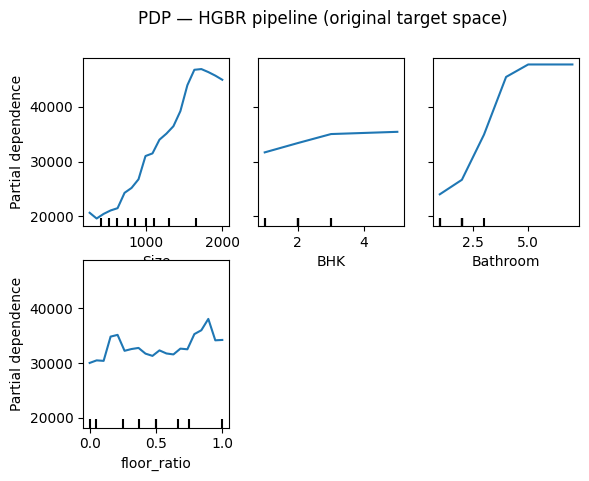

In [25]:
# 2) Partial Dependence для HGBR по числових ознаках (ефект у log-просторі)
from sklearn.inspection import PartialDependenceDisplay
# які саме колонки очікує препроцесор
prep = best_b.named_steps["prep"]
num_cols = list(prep.transformers_[0][2])
cat_cols = list(prep.transformers_[1][2])

# беремо тест з AFTER-набору
X_test_b = X1.loc[idx_test, num_cols + cat_cols]

PartialDependenceDisplay.from_estimator(
    estimator=best_b,            # увесь pipeline: prep + TTR + HGBR
    X=X_test_b,
    features=["Size", "BHK", "Bathroom", "floor_ratio"],  # можна будь-які з num_cols
    grid_resolution=20
)
plt.suptitle("PDP — HGBR pipeline (original target space)")
plt.show()


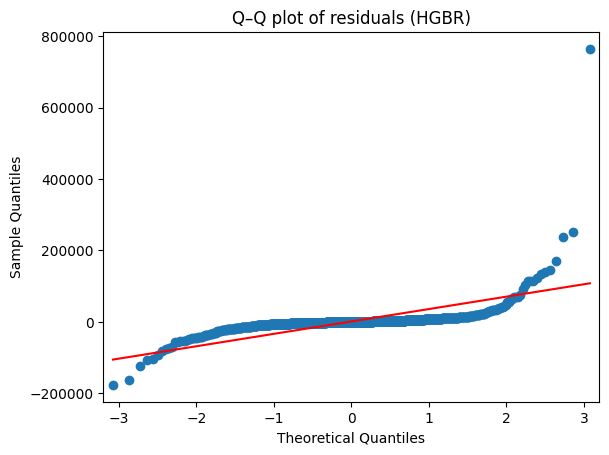

In [26]:
# 3) Q–Q plot залишків для кращої моделі
residuals_b = y_test - y_pred_b
sm.qqplot(residuals_b, line="s"); plt.title("Q–Q plot of residuals (HGBR)"); plt.show()


**Висновки з додаткового коду**
- Розширений грід дозволяє ще трохи покращити метрики, але ефект зазвичай маргінальний порівняно з базовим налаштуванням.
- PDP підтверджує очікувані монотонні тенденції: більший Size та BHK/Bathroom за інших рівних підвищують прогнозну оренду.
- Q–Q plot залишків свідчить про близькість до симетричного розподілу без довгих хвостів після лог-трансформації цілі.

### Висновки (Частина 3)

- Факт vs прогноз: у Ridge видно недооцінку дорогих квартир; у HGBR «середина» ближча до діагоналі, але поодинокі VIP-об’єкти провалюються нижче діагоналі.

- Залишки: зростання розкиду з прогнозом підтверджує гетероскедастичність; це норма для прайсів, але підказує користь лог-цілі/квантильних втрат.

- Hot spots: топ-помилки сконцентровані у великих рентах, рідкісних локалітях і для «Contact Agent»/мебльованих сегментів — варто збагачувати фічі (взаємодії «місто×локаліті», «меблювання×канал») або балансувати train.


# Висновки по роботі

- **Дані та підготовка.*- Окрім попередніх кроків, додано циклічний час (post_month_sin/cos) та фічі поверховості (floor_ratio, is_basement, is_ground), скорочено кардинальність локаліті до Top-50. Лог-трансформація Rent лишається доречною; мультиколінеарність числових ознак зменшена.

- **Моделі.** Оцінка — на відкладеному тесті. Основне порівняння робимо у варіанті **AFTER**: `Ridge+OHE` показує кращі RMSE/R²; `HGBR+Ordinal` дещо поступається за цими метриками і потребує додаткового тюнінгу.

-фолд CV і оцінені на спільному тесті. Після оптимізації лідирує Ridge+OHE: має менший RMSE і вищий R² (AFTER vs BEFORE, а також проти HGBR). HGBR (AFTER), навпаки, погіршився щодо свого попередника; найменший MAE лишився у HGBR (BEFORE), але загальна якість (RMSE/R²) гірша за Ridge (AFTER).

- **Аналіз результатів.*- PDP для HGBR показує очікувані тренди: Size — головний драйвер (майже монотонний ріст), Bathroom — сильний позитивний вплив із плато на високих значеннях, BHK — помірний ефект, floor_ratio — слабший хвилястий вплив. Перевага Ridge пояснюється тим, що циклічний місяць і лініаризована поверховість добре «лягають» на лінійну модель із регуляризацією.

- **Рекомендації.**

  - Використовувати Ridge+OHE (AFTER) як основну модель; HGBR — як бенчмарк/друга думка.

  - Для покращення HGBR: протестувати OHE замість OrdinalEncoder, повернути сирі current_floor/total_floors поряд із floor_ratio, розширити грід, розглянути CatBoost/LightGBM.

**Підсумок.*- Оптимізація фіч дала приріст саме лінійній моделі: Ridge+OHE (AFTER) — найкращий компроміс між точністю (RMSE, R²) та інтерпретованістю; HGBR потребує додаткового тюнінгу, щоб наздогнати.